## Setup


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!pip install sewar==0.4.4
!pip install keras-flops
from skimage.util import random_noise
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import cv2
import glob
from google.colab.patches import cv2_imshow
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Flatten, Reshape, Softmax, Lambda
from keras.models import Model, Sequential
from keras_flops import get_flops
from tensorflow.keras.optimizers import Adam
import torch
import torchvision
from skimage.metrics import structural_similarity as ssim
import sewar
from sklearn import cluster
from sklearn import decomposition
import PIL

print(tf.__version__)

# access google file system
from google.colab import drive
drive.mount('/content/drive')
# change this to your own directory
cwd = '/content/drive/My Drive/vae/'

Found GPU at: /device:GPU:0
2.7.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
def load_celeb_images(file_path):
    raw_image_dataset = tf.data.TFRecordDataset(file_path)

    # Create a dictionary describing the features.
    image_feature_description = {
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'data': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([1], tf.int64)
    }

    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, image_feature_description)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    
    images = []
    for image_features in parsed_image_dataset:
        image_raw = image_features['data'].numpy()
        shape = image_features['shape'].numpy()
        img = tf.io.decode_raw(image_raw, tf.uint8)
        img = tf.reshape(img, shape).numpy()
        images.append(img)
    return images

def get_image_grid(images_np, nrow=8):
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=20, interpolation='lanczos'):
    images_np = np.swapaxes(np.swapaxes(images_np, 1, 3), 2,3)
    n_channels = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

## Generate Noisy Images

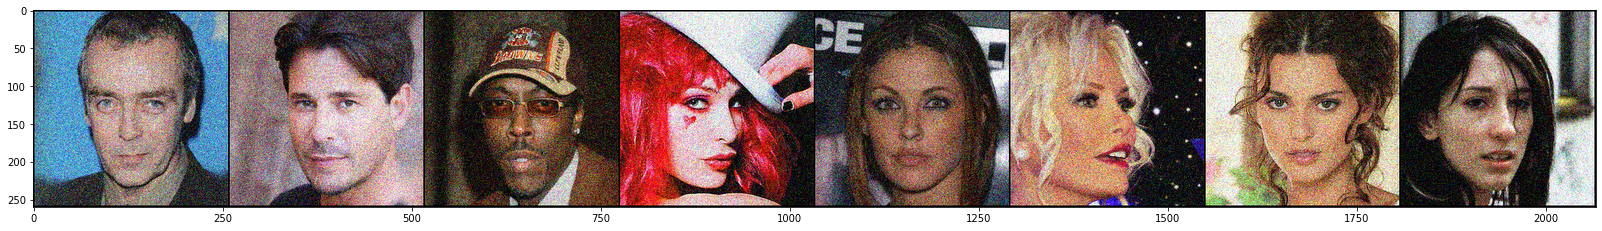

In [ ]:
def gen_noise(images):
    noise = []
    for img in images:
        noise_image = np.copy(img)
        noise_img = random_noise(noise_image, mode='gaussian',var=0.02)
        noise_image = np.array(255*noise_img, dtype = 'uint8')
        noise.append(noise_image)
    return noise

#clear image: images
clear_images = load_celeb_images(cwd + 'celeba_train/train-r08-s-0001-of-0120.tfrecords')[:32]
clear_copy = np.array(clear_images)
noise_images = gen_noise(clear_images)
plot_image_grid(noise_images[8:16])

## Divide and Merge Images

In [ ]:
BLOCK_SIZE = 16
NUM_BLOCK = 21
OVERLAP = 4

BLOCK_PER_IMAGE = NUM_BLOCK * NUM_BLOCK
WIDTH = len(clear_images[0][0])
HEIGHT = len(clear_images[0])
NUM_CLUSTER = 1
SHAPE = (BLOCK_SIZE, BLOCK_SIZE, 3)
BATCH_SIZE = max(10000, BLOCK_PER_IMAGE)

print(BLOCK_PER_IMAGE, SHAPE, WIDTH, HEIGHT)

441 (16, 16, 3) 256 256


In [ ]:
def divide_img(img, block_size=18, num_block=18, overlap=4):
    height = len(img)
    width = len(img[0])
    if not (block_size*num_block - (num_block - 1)*overlap == height):
        raise ValueError('Block size mismatch', 
                          block_size*num_block - (num_block - 1)*overlap, height)
    size = block_size - overlap
    blocks = np.array([img[i:i+block_size, j:j+block_size] 
                      for j in range(0,width - overlap,size) 
                      for i in range(0,height - overlap,size)])
    return blocks

def merge_img(blocks, width=256, height=256, block_size=18, overlap=4):
    num_block_per_row = (width - overlap)//(block_size - overlap)
    num_block_per_col = (height - overlap)//(block_size - overlap)
    def get_row_block(row):
        row_block = blocks[row]
        for j in range(1, num_block_per_row):
            cur_row_block = row_block[:, :len(row_block[0]) - overlap]
            block1 = blocks[row+j*num_block_per_col]
            cur_block = block1[:, overlap:]
            lapping = row_block[:, len(row_block[0]) - overlap:]
            lapping1 = block1[:, :overlap]
            for k in range(0, overlap):
                lapping[:, k] *= 1 - (k+1)/(overlap+1)
                lapping1[:, k] *= (k+1)/(overlap+1)
            lap = lapping + lapping1
            row_block = np.concatenate([cur_row_block, lap, cur_block], axis=1)
        return row_block

    img = get_row_block(0)
    for i in range(1, num_block_per_col):
        cur_block = img[:len(img)-overlap]
        cur_row = get_row_block(i)
        lapping = img[len(img)-overlap:]
        lapping1 = cur_row[:overlap]
        cur_row = cur_row[overlap:]
        for k in range(0, overlap):
            lapping[k,:] *= 1 - (k+1)/(overlap+1)
            lapping1[k,:] *= (k+1)/(overlap+1)
        lap = lapping + lapping1
        img = np.concatenate([cur_block, lap, cur_row], axis=0)
    return img

def gen_train_set(clear_imgs, blur_imgs, shape, block_size, num_block, overlap):
    noise_images = np.expand_dims(np.zeros(shape), 0)
    clear_images = np.expand_dims(np.zeros(shape), 0)

    for i in range(len(clear_imgs)):
        blocks = divide_img(clear_imgs[i], block_size, num_block, overlap)
        clear_images = np.concatenate([clear_images, blocks])
        blur_blocks = divide_img(blur_imgs[i], block_size, num_block, overlap)
        noise_images = np.concatenate([noise_images, blur_blocks])
    return clear_images[1:]/255, noise_images[1:]/255

In [ ]:
clear_images, noise_images = gen_train_set(clear_images, noise_images, SHAPE,
                                           BLOCK_SIZE, NUM_BLOCK, OVERLAP)
print(noise_images.shape, clear_images.shape)

(14112, 16, 16, 3) (14112, 16, 16, 3)


## Model

In [ ]:
def build_encoder(shape):
    encoder_inputs = keras.Input(shape=shape)
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same", 
                      kernel_regularizer=regularizer)(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(48, 3, activation="relu", strides=1, padding="same", 
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same", 
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(72, 3, activation="relu", strides=2, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z = layers.Dense(128, activation="relu")(x)
    encoder = keras.Model(encoder_inputs, z, name="encoder")
    return encoder

def build_classifier(num_cluster):
    x = keras.Input(shape=(128,))
    y_hid = layers.Dense(64, activation="relu")(x)
    y_logits = layers.Dense(num_cluster, activation="linear")(y_hid)
    y = layers.Softmax()(y_logits)
    y_logits = layers.Softmax()(y_logits)
    return keras.Model(x, [y, y_logits], name="classifier")

def build_decoder(shape):
    latent_inputs = keras.Input(shape=(128,))
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Dense(shape[0] * shape[1] * 16, activation="relu",
                    kernel_regularizer=regularizer)(latent_inputs)
    x = layers.Reshape((shape[0]//4, shape[1]//4, 256))(x)
    x = layers.Conv2DTranspose(72, 3, activation="relu", strides=2,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(48, 3, activation="relu", strides=1,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1,
                               kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, 
                              kernel_regularizer=regularizer, padding="same")(x)
    output = layers.Conv2DTranspose(3, 3, 
                                    activation="sigmoid", 
                                    kernel_regularizer=regularizer, 
                                    padding="same")(x)
    decoder = keras.Model(latent_inputs, output)
    return decoder

class My_Model(keras.Model):
    def __init__(self, encoder=None, num_cluster=1, **kwargs):
        super(My_Model, self).__init__(**kwargs)
        self.encoder = encoder
        if encoder == None:
            self.encoder = build_encoder(SHAPE)
        self.decoder = build_decoder(SHAPE)
        self.classifier = build_classifier(num_cluster)
        self.num_cluster = num_cluster
        self.shape = SHAPE

    def call(self, x):
        return self.decoder(self.encoder(x))

    def elbo_loss(self, x, target):
        mse = tf.reduce_mean(keras.losses.MSE(target, x))
        mse *= self.shape[0] * self.shape[1]
        kld = tf.keras.losses.KLDivergence()(target, x)
        return mse + kld

    def train_step(self, inputs):
        x = inputs[0][0]
        target = inputs[0][1]
        # x: [batch * height * width * channel], noise image
        # target: [batch * height * width * channel], clean image
        with tf.GradientTape() as tape:
            x = self.decoder(self.encoder(x))
            elbo_loss = self.elbo_loss(x, target)
        grads = tape.gradient(elbo_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))

        with tf.GradientTape() as tape_y:
            z = self.encoder(x)
            y, y_logits = self.classifier(z)
            y_kl_loss = tf.reduce_mean(tf.reduce_sum(y_logits * (tf.math.log(y_logits + 1e-8) - tf.math.log(1.0/self.num_cluster)), axis=1))
        grads = tape_y.gradient(y_kl_loss, self.classifier.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.classifier.trainable_weights))
        return {
            "elbo_loss": elbo_loss,
            "y_kl_loss": y_kl_loss,
        }

class Model_P(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(Model_P, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        return self.decoder(self.encoder(x))

    def train_step(self, inputs):
        x, target = inputs[0][0], inputs[0][1]
        with tf.GradientTape() as tape:
            x = self.decoder(self.encoder(x))
            elbo_loss = tf.reduce_mean(keras.losses.MSE(target, x)) * SHAPE[0] * SHAPE[1] + tf.keras.losses.KLDivergence()(target, x)
        grads = tape.gradient(elbo_loss, self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.decoder.trainable_weights))
        return {
            "elbo_loss": elbo_loss,
        }

In [ ]:
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.encoder = build_encoder(SHAPE)
        self.temperature = 0.1
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(128,)),
                layers.Dense(128, activation="relu"),
                layers.Dense(128),
            ],
            name="projection_head",
        )

    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer

        # self.contrastive_loss will be defined as a method
        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (augmented_images_1, augmented_images_2) = data[0]

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        return {m.name: m.result() for m in self.metrics}

pretraining_model = ContrastiveModel()
pretraining_model.encoder = keras.models.load_model(cwd + 'pretrained models/celeba_contrastive_encoder')

In [ ]:
encoder = keras.models.load_model(cwd + 'pretrained models/celeba_encoder')
decoders = [keras.models.load_model(cwd + 'pretrained models/celeba_decoder1'),
            keras.models.load_model(cwd + 'pretrained models/celeba_decoder2')]
classifier = keras.models.load_model(cwd + 'pretrained models/celeba_classifier')

## Reconstruction

In [ ]:
def decode_images(x, encoder, classifier, decoders):
    z = encoder.predict(x)
    y,_ = classifier.predict(z)
    decoded_images = []
    decode = []
    for i in range(len(decoders)):
        decode.append(decoders[i].predict(z))
    for i in range(len(y)):
        decode_img = decode[np.argmax(y[i])][i]
        decoded_images.append(decode_img)
    return decoded_images

def reconstruct_image(noise_blocks, encoder, classifier, decoders, 
                      block_per_image, width, height, block_size, overlap):
    recons_images = []
    decoded_images = decode_images(noise_blocks[:10000], encoder, classifier, decoders)
    for i in range(10000, len(noise_blocks), 10000):
        decoded_images = np.concatenate([decoded_images, 
                                         decode_images(noise_blocks[i:i+10000], encoder, classifier, decoders)], 
                                        axis=0)

    blocks = decoded_images[: block_per_image]
    image = merge_img(blocks, width, height, block_size, overlap)
    recons_images = np.array([image])
    for i in range(block_per_image, len(decoded_images), block_per_image):
        blocks = decoded_images[i: i+block_per_image]
        image = merge_img(blocks, width, height, block_size, overlap)
        recons_images = np.concatenate([recons_images, np.array([image])], axis=0)
    return (recons_images*255).astype(np.uint8)

recons_images = reconstruct_image(noise_images, encoder, classifier, decoders, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)

## Evaluation

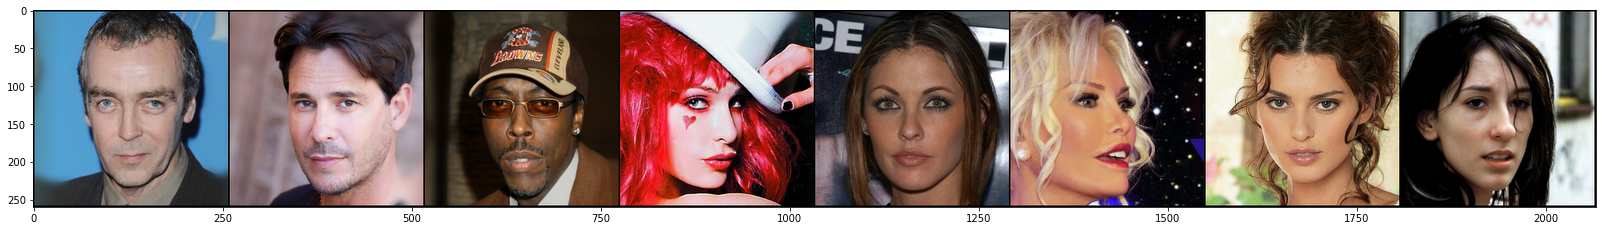

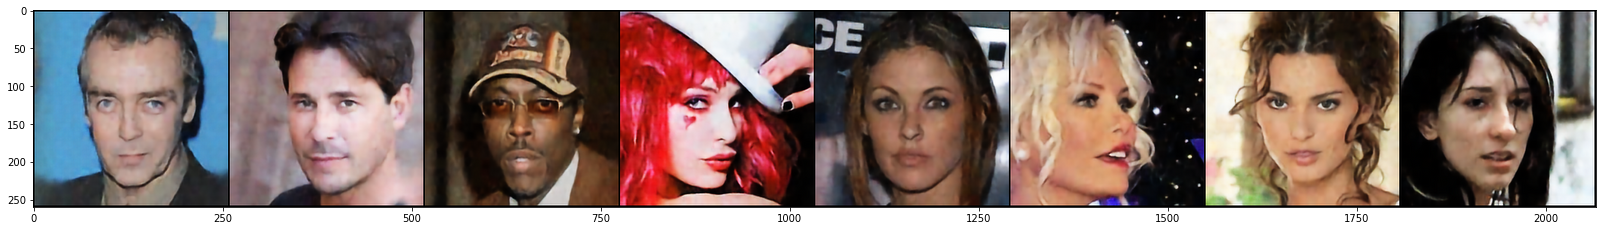

PSNR
29.720665708192016


29.720665708192016

In [ ]:
def quality_evaluation(recons_images, test_images, metric='PSNR', display=True):
    recons = []
    for i in range(len(recons_images)):
        metric_recons = 0
        if metric == 'PSNR':
            metric_recons = cv2.PSNR(recons_images[i], test_images[i])
        elif metric == 'SSIM':
            metric_recons = ssim(recons_images[i], test_images[i], multichannel=True)
        elif metric == 'UQI':
            metric_recons = sewar.full_ref.uqi(recons_images[i], test_images[i], ws=8)
        recons.append(metric_recons)
    if display:
        print(metric)
        print(np.array(recons).mean())
    return np.array(recons).mean()

plot_image_grid(clear_copy[8:16])
plot_image_grid(recons_images[8:16])
quality_evaluation(recons_images, clear_copy)